In [6]:
!jupyter nbextension enable toc2/main

Enabling notebook extension toc2/main...
      - Validating: problems found:
        - require?  X toc2/main


### Project Understanding 
##### Recent fires from 2020 have brought up various concerns from the health implications to possible understanding / prevention that can carried out by understanding characteristics of the fire.  Therefore, this jupyter notebook puts together a framework for others to understand the current database and provide framework to run analysis on new attributes

### Data Understanding
* CALIFREPORTINGDB_H2O 
* MASTER021920 (MASTER, join by CARDBRECID - California Reporting DB ID, BPS140, EVT140, EVT130, EVT120, EVT110, EVT105, LEMMA_CODE, MGMTSCAP_V, HUC12)
* BURNSEVERITY2020 (TARGET - Severity 1-4, join by CARDBRECID)  
* FROM landfire.gov/version_comparison.php 
* CA_BPS140 (ATTRIBUTE - Biophsical Setting, join by BPS140) 
* CA_EVT110 (ATTRIBUTE - Existing Vegtation Type - 2008, join by VALUE)
* CA_EVT120 (ATTRIBUTE - Existing Vegtation Type - 2010, join by VALUE)
* CA_EVT130 (ATTRIBUTE - Existing Vegtation Type - 2012, join by VALUE)
* CA_EVT140 (ATTRIBUTE - Existing Vegtation Type - 2014, join by VALUE)
* CENSUS_BLK_PLACE_INCORP #### ELEV (ATTRIBUTE, join by CARDBRECID)
* GEO_LAT_LON (ATTRIBUTE, join by CARDBRECID)
* SALO_BD_ADAM_TEST (ATTRIBUTE, join by CARDBRECID)
* TUBBSING_TREE_MORTALITY (ATTRIBUTE, join by CARDBRECID)

In [7]:

import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import getpass
import seaborn as sns

import pandas as pd 
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.transforms

In [8]:
ctx = snowflake.connector.connect(
    user='filipiyada7',
    password=getpass.getpass('password: '),
    account='dva61212',
    warehouse='COMPUTE_WH',
    database='CALIFREPORTINGDB_H20',
    schema='PUBLIC',
    protocol='https'
)
cur = ctx.cursor()

In [9]:
query = '''
USE ROLE ACCOUNTADMIN;
'''

cur.execute(query)

In [10]:
query = '''
USE DATABASE DEMO_DB;'''
cur.execute(query)

In [11]:
query = '''
SELECT * FROM PUBLIC.FIRE_SEVERITY'''

cur.execute(query)
df = cur.fetch_pandas_all()

In [ ]:
df

In [22]:
query = '''
SELECT * FROM PUBLIC.FIRE_SEVERITY WHERE FIRE_NAME='Castle'
'''
cur.execute(query)
df_castle = cur.fetch_pandas_all()

In [11]:
df_castle

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,283498198,3,-151,-118.51076,36.10544,"{\n ""coordinates"": [\n -1.185107600000000e...",Sh California Montane Woodland and Chaparral,11,2267,135,Castle
1,283512584,4,68191,-118.48878,36.10939,"{\n ""coordinates"": [\n -1.184887800000000e...",Tr California Montane Jeffrey Pine(-Ponderosa ...,25,2366,138,Castle
2,283627069,4,133482,-118.51724,36.10171,"{\n ""coordinates"": [\n -1.185172400000000e...",Tr Mediterranean California Mesic Mixed Conife...,13,2221,295,Castle
3,283641495,3,-132,-118.48382,36.10786,"{\n ""coordinates"": [\n -1.184838200000000e...",Sps Inter-Mountain Basins Sparsely Vegetated S...,48,2356,128,Castle
4,283842059,3,128151,-118.48958,36.10290,"{\n ""coordinates"": [\n -1.184895800000000e...",Tr Mediterranean California Mixed Oak Woodland,22,2007,176,Castle
...,...,...,...,...,...,...,...,...,...,...,...
760839,278733081,3,68121,-118.51245,36.19660,"{\n ""coordinates"": [\n -1.185124500000000e...",Tr Mediterranean California Mesic Mixed Conife...,15,2060,75,Castle
760840,278805173,4,106501,-118.55001,36.18800,"{\n ""coordinates"": [\n -1.185500100000000e...",Tr Mediterranean California Red Fir Forest,14,2353,5,Castle
760841,278935255,4,143592,-118.51167,36.19289,"{\n ""coordinates"": [\n -1.185116700000000e...",Tr Mediterranean California Mesic Mixed Conife...,29,2167,53,Castle
760842,278949634,4,106313,-118.53155,36.18880,"{\n ""coordinates"": [\n -1.185315500000000e...",Tr California Montane Riparian Systems,2,2332,-1,Castle


In [26]:
query = '''
SELECT * FROM PUBLIC.FIRE_SEVERITY AS M WHERE FIRE_NAME = 'Claremont-Bear'
'''
cur.execute(query)
df_claremont = cur.fetch_pandas_all()

In [13]:
df_claremont

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,106771966,4,106677,-121.30606,39.71465,"{\n ""coordinates"": [\n -1.213060600000000e...",Tr Mediterranean California Mesic Mixed Conife...,16,1054,129,Claremont-Bear
1,106580234,4,104365,-121.27186,39.72643,"{\n ""coordinates"": [\n -1.212718600000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,36,1069,175,Claremont-Bear
2,106681759,4,104075,-121.28875,39.72045,"{\n ""coordinates"": [\n -1.212887500000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,36,773,172,Claremont-Bear
3,106760674,4,95821,-121.30990,39.71413,"{\n ""coordinates"": [\n -1.213099000000000e...",Tr Mediterranean California Mesic Mixed Conife...,12,1077,172,Claremont-Bear
4,106794627,4,101930,-121.27146,39.72124,"{\n ""coordinates"": [\n -1.212714600000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,36,744,216,Claremont-Bear
...,...,...,...,...,...,...,...,...,...,...,...
1108716,105733383,1,133833,-120.89257,39.82488,"{\n ""coordinates"": [\n -1.208925700000000e...",Tr Mediterranean California Red Fir Forest,8,1975,64,Claremont-Bear
1108717,105789982,4,104135,-120.89450,39.82310,"{\n ""coordinates"": [\n -1.208945000000000e...",Tr Mediterranean California Red Fir Forest,2,2018,-1,Claremont-Bear
1108718,105801308,3,73665,-120.89236,39.82326,"{\n ""coordinates"": [\n -1.208923600000000e...",Tr Mediterranean California Red Fir Forest,14,1975,118,Claremont-Bear
1108719,105925809,2,104321,-120.89238,39.82021,"{\n ""coordinates"": [\n -1.208923800000000e...",Tr Mediterranean California Red Fir Forest,24,2000,38,Claremont-Bear


In [14]:
query = '''
SELECT * FROM FIRE_SEVERITY WHERE FIRE_NAME ='Creek'
'''
cur.execute(query)
df_creek = cur.fetch_pandas_all()


In [23]:
df_creek

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,226285215,2,139478,-119.02084,37.14431,"{\n ""coordinates"": [\n -1.190208400000000e...",Tr Mediterranean California Red Fir Forest,6,2663,96,Creek
1,226899002,2,147985,-119.02957,37.12965,"{\n ""coordinates"": [\n -1.190295700000000e...",Tr Mediterranean California Red Fir Forest,4,2745,0,Creek
2,226337362,3,139478,-119.02647,37.14211,"{\n ""coordinates"": [\n -1.190264700000000e...",Tr Mediterranean California Red Fir Forest,9,2724,106,Creek
3,226846704,2,72286,-119.02692,37.13127,"{\n ""coordinates"": [\n -1.190269200000000e...",Tr Sierra Nevada Subalpine Lodgepole Pine Fore...,8,2709,74,Creek
4,227317876,1,139478,-119.01306,37.12403,"{\n ""coordinates"": [\n -1.190130600000000e...",Tr Mediterranean California Red Fir Forest,4,2576,90,Creek
...,...,...,...,...,...,...,...,...,...,...,...
1666509,203116999,1,88529,-119.22231,37.62509,"{\n ""coordinates"": [\n -1.192223100000000e...",Tr Mediterranean California Mesic Mixed Conife...,19,2211,118,Creek
1666510,203260635,4,68119,-119.23796,37.61874,"{\n ""coordinates"": [\n -1.192379600000000e...",Sh California Montane Woodland and Chaparral,37,2407,167,Creek
1666511,203332514,4,131517,-119.22681,37.61925,"{\n ""coordinates"": [\n -1.192268100000000e...",Tr Mediterranean California Mesic Mixed Conife...,12,2129,167,Creek
1666512,204780881,4,132896,-119.22442,37.58634,"{\n ""coordinates"": [\n -1.192244200000000e...",Tr California Montane Jeffrey Pine(-Ponderosa ...,34,2026,193,Creek


In [15]:
df.describe()

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
count,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06
mean,1.947901e+08,2.879853e+00,9.985694e+04,-1.197058e+02,3.784733e+01,1.754489e+01,1.687319e+03,1.865626e+02
std,6.411320e+07,1.217569e+00,3.450692e+04,1.021938e+00,1.354855e+00,9.873920e+00,5.116336e+02,1.013470e+02
min,9.858018e+07,1.000000e+00,-2.860000e+02,-1.213360e+02,3.610000e+01,0.000000e+00,2.640000e+02,-1.000000e+00
25%,1.102513e+08,2.000000e+00,7.777300e+04,-1.210294e+02,3.710752e+01,1.000000e+01,1.313000e+03,1.080000e+02
50%,2.133674e+08,3.000000e+00,1.032750e+05,-1.193248e+02,3.738527e+01,1.600000e+01,1.684000e+03,1.930000e+02
75%,2.252187e+08,4.000000e+00,1.307090e+05,-1.190876e+02,3.964988e+01,2.400000e+01,2.085000e+03,2.730000e+02
max,2.853213e+08,4.000000e+00,1.486940e+05,-1.182997e+02,3.991000e+01,7.400000e+01,3.311000e+03,3.590000e+02


In [15]:
query = '''
SELECT BURNSEVERITY2020BA4, LEMMA_CODE, LON, LAT,SLOPE,ELEV_M,ASPECT FROM PUBLIC.FIRE_SEVERITY
''' 
cur.execute(query)
df_regression = cur.fetch_pandas_all()
df_regression

,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
0,1,102331,-119.02248,37.14730,12,2654,67
1,4,129968,-119.02277,37.13704,7,2649,98
2,2,129968,-119.01832,37.10950,12,2657,130
3,1,102378,-119.01918,37.14573,7,2635,57
4,2,147985,-119.03024,37.12842,6,2759,22
...,...,...,...,...,...,...,...
3536074,4,136709,-118.67943,36.36094,22,2492,227
3536075,4,89271,-118.67509,36.36151,22,2657,220
3536076,1,143888,-118.72178,36.38915,18,2572,337
3536077,1,88126,-118.69900,36.36020,15,1892,303


In [16]:
# Remove colomns with strings
# df = df.drop(['GEO_SHP', 'EVT_FUEL_N', 'FIRE_NAME'], axis=1)

features = df_regression.iloc[:, 1:]
target = df_regression['BURNSEVERITY2020BA4']
features

,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
0,102331,-119.02248,37.14730,12,2654,67
1,129968,-119.02277,37.13704,7,2649,98
2,129968,-119.01832,37.10950,12,2657,130
3,102378,-119.01918,37.14573,7,2635,57
4,147985,-119.03024,37.12842,6,2759,22
...,...,...,...,...,...,...
3536074,136709,-118.67943,36.36094,22,2492,227
3536075,89271,-118.67509,36.36151,22,2657,220
3536076,143888,-118.72178,36.38915,18,2572,337
3536077,88126,-118.69900,36.36020,15,1892,303


In [27]:
# features = df.iloc[:, 1:]
# target = df['BURNSEVERITY2020BA4']
# features

In [28]:
target

0          1
1          4
2          2
3          1
4          2
          ..
3536074    4
3536075    4
3536076    1
3536077    1
3536078    1
Name: BURNSEVERITY2020BA4, Length: 3536079, dtype: int8

### Data Exploration 
#### [Reference Tutorial](https://medium.com/@vijain2010/beginners-guide-to-feature-selection-techniques-using-python-4d23fcb8951a)

#### Feature Selection

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [18]:
# sample: 
# 1. define features & target; 2. run model specific model; 3. Find best feature

import pandas as pd
# import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# from sklearn.datasets import load_wine
# dataset =load_wine()
# X, Y = dataset.data, dataset.target

X, Y = features, target

model = LogisticRegression(random_state=0, solver='saga',multi_class='multinomial').fit(X,Y)
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print( fit.n_features_) 
print("Selected Features: %s"% fit.support_) 
print("Feature Ranking: %s"% fit.ranking_)

# output:
# 5
# Selected Features: [ True False  True False False False  True False False  True False  True
#  False]
# Feature Ranking: [1 4 1 5 8 7 1 3 6 1 2 1 9]

# output 
# 5 
# Selected Features: [False  True  True  True  True  True] 
# Feature Ranking: [2 1 1 1 1 1]

# RAN 12 MIN

5
Selected Features: [False  True  True  True  True  True]
Feature Ranking: [2 1 1 1 1 1]


In [30]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2,p,dof,ex = ss.chi2_contingency(confusion_matrix)

    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2/min((k-1),(r-1)))

#### [Calculate feature importance](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

### Linear regression feature importance

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.93725
Feature: 2, Score: -0.69027
Feature: 3, Score: -0.00291
Feature: 4, Score: -0.00036
Feature: 5, Score: -0.00011


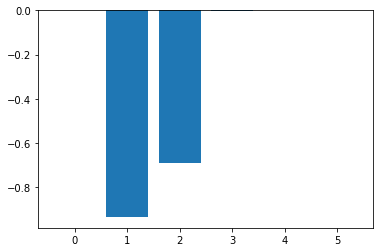

In [19]:
#Linear regression feature importance
from sklearn.datasets import make_regression 
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt


X, Y = features, target

# define the model 
model = LinearRegression() 
# fit the model 
model.fit(X, Y) 
# get importance 
importance = model.coef_ 
# summarize feature importance 
for i,v in enumerate(importance):  print('Feature: %0d, Score: %.5f' % (i,v)) 
# plot feature importance 
plt.bar([x for x in range(len(importance))], importance)
plt.show()   


### Logistic regression feature importance

Feature: 0, Score: -0.00000
Feature: 1, Score: 0.00066
Feature: 2, Score: -0.00021
Feature: 3, Score: -0.00014
Feature: 4, Score: 0.00031
Feature: 5, Score: -0.00095


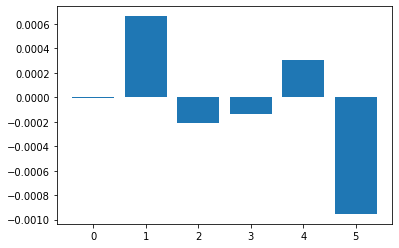

In [39]:
# logistic regression for feature importance 
from sklearn.datasets import make_classification 
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt
# define the model 
model = LogisticRegression() 
# fit the model 
model.fit(X, Y) 
# get importance 
importance = model.coef_[0] 
# summarize feature importance 
for i,v in enumerate(importance): print('Feature: %0d, Score: %.5f' % (i,v)) 
# plot feature importance 
plt.bar([x for x in range(len(importance))], importance) 
plt.show()



### Decision tree feature importance - with regression

Feature: 0, Score: 0.02517
Feature: 1, Score: 0.33774
Feature: 2, Score: 0.32727
Feature: 3, Score: 0.04634
Feature: 4, Score: 0.17568
Feature: 5, Score: 0.08780


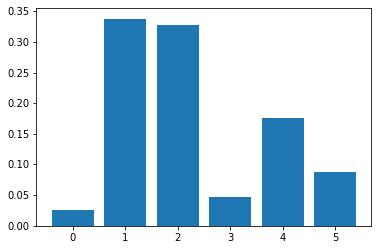

In [41]:
# from sklearn.datasets import make_regression 
from sklearn.tree import DecisionTreeRegressor 
import matplotlib.pyplot as plt
# define the model 
model = DecisionTreeRegressor() 
# fit the model 
model.fit(X, Y) 
# get importance 
importance = model.feature_importances_ 
# summarize feature importance 
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v)) 
# plot feature importance 
plt.bar([x for x in range(len(importance))], importance) 
plt.show()


### Decision tree feature importance - with classifier

Feature: 0, Score: 0.05073
Feature: 1, Score: 0.28533
Feature: 2, Score: 0.30708
Feature: 3, Score: 0.07057
Feature: 4, Score: 0.16915
Feature: 5, Score: 0.11713


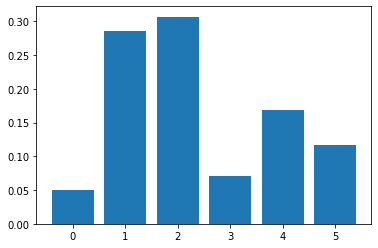

In [43]:
# from sklearn.datasets import make_classification 
from sklearn.tree import DecisionTreeClassifier 
import matplotlib.pyplot as plt
# define the model 
model = DecisionTreeClassifier() 
# fit the model 
model.fit(X, Y) 
# get importance 
importance = model.feature_importances_ 
# summarize feature importance
for i,v in enumerate(importance):  print('Feature: %0d, Score: %.5f' % (i,v)) 
# plot feature importance 
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Random forest feature importance - with regression

In [45]:
from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor() 
model.fit(X, Y) 
importance = model.feature_importances_ 
for i,v in enumerate(importance):  print('Feature: %0d, Score: %.5f' % (i,v)) 
plt.bar([x for x in range(len(importance))], importance) 
plt.show()

Error: ModuleNotFoundError

### Random forest feature importance - with classification

In [12]:
# random forest for feature importance on a regression problem 
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier() 
model.fit(X, Y) 
importance = model.feature_importances_ 
for i,v in enumerate(importance): print('Feature: %0d, Score: %.5f' % (i,v)) 

plt.bar([x for x in range(len(importance))], importance) 
plt.show()

NameError: name 'X' is not defined

### Spearman's Correlation

In [23]:
# Spearman's correlation is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables)
# It assesses how well the relationship between two variables can be described using a monotonic function

# change method to Spearman 
df_castle.corr(method='spearman')


,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
CARDBRECID,1.000000,0.300871,0.073949,0.669899,-0.959133,-0.223806,-0.057895,-0.093669
BURNSEVERITY2020BA4,0.300871,1.000000,0.068253,0.229382,-0.278050,-0.076468,0.073113,-0.084859
LEMMA_CODE,0.073949,0.068253,1.000000,0.009491,-0.081287,-0.120764,-0.055854,0.020260
LON,0.669899,0.229382,0.009491,1.000000,-0.452998,-0.138817,0.218228,-0.075289
LAT,-0.959133,-0.278050,-0.081287,-0.452998,1.000000,0.229527,0.128845,0.089381
SLOPE,-0.223806,-0.076468,-0.120764,-0.138817,0.229527,1.000000,-0.006908,0.104505
ELEV_M,-0.057895,0.073113,-0.055854,0.218228,0.128845,-0.006908,1.000000,-0.047470
ASPECT,-0.093669,-0.084859,0.020260,-0.075289,0.089381,0.104505,-0.047470,1.000000


In [24]:
df_creek.corr(method='spearman')

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
CARDBRECID,1.000000,0.187755,0.029160,-0.128184,-0.984876,0.053168,-0.402272,0.068223
BURNSEVERITY2020BA4,0.187755,1.000000,0.026739,-0.225867,-0.215045,0.126985,-0.331021,-0.010932
LEMMA_CODE,0.029160,0.026739,1.000000,-0.017271,-0.036877,-0.062832,-0.020824,0.055914
LON,-0.128184,-0.225867,-0.017271,1.000000,0.285486,-0.026700,0.545437,0.055092
LAT,-0.984876,-0.215045,-0.036877,0.285486,1.000000,-0.062704,0.479552,-0.058899
SLOPE,0.053168,0.126985,-0.062832,-0.026700,-0.062704,1.000000,-0.198093,0.130522
ELEV_M,-0.402272,-0.331021,-0.020824,0.545437,0.479552,-0.198093,1.000000,-0.024616
ASPECT,0.068223,-0.010932,0.055914,0.055092,-0.058899,0.130522,-0.024616,1.000000


In [27]:
df_claremont.corr(method='spearman')

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
CARDBRECID,1.000000,0.311894,-0.060440,-0.184492,-0.950594,-0.075180,-0.558847,0.058823
BURNSEVERITY2020BA4,0.311894,1.000000,-0.048161,-0.188397,-0.340430,-0.097886,-0.121140,0.028251
LEMMA_CODE,-0.060440,-0.048161,1.000000,0.082964,0.074867,-0.076156,0.107778,-0.012057
LON,-0.184492,-0.188397,0.082964,1.000000,0.451014,0.037230,0.529766,-0.053586
LAT,-0.950594,-0.340430,0.074867,0.451014,1.000000,0.091260,0.633743,-0.069066
SLOPE,-0.075180,-0.097886,-0.076156,0.037230,0.091260,1.000000,-0.276173,0.045884
ELEV_M,-0.558847,-0.121140,0.107778,0.529766,0.633743,-0.276173,1.000000,-0.031602
ASPECT,0.058823,0.028251,-0.012057,-0.053586,-0.069066,0.045884,-0.031602,1.000000


### Verify Spearman Correlation with p-value
* [How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

In [28]:
x = df_creek[["BURNSEVERITY2020BA4"]]
x.astype('int16').dtypes
y = df_creek[["ELEV_M"]]

#x.to_numpy()
#y.to_numpy()

# scipy.stats.pearsonr(x.astype('int16').dtypes, y)  
# ValueError: x and y must have the same length. but checked x and y both has count of :1.666514e+06 
# x.describe()
# y.describe()

from scipy import stats
rho, pval = stats.spearmanr(x,y)

In [29]:
print('For Creek Fire Severity and Elevation\nSpearmans correlation coefficient: %.3f' % rho) 
# interpret the significance 
alpha = 0.05 
if pval > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % pval)
else:
    print('Samples are correlated (reject H0) p=%.3f' % pval)

For Creek Fire Severity and Elevation
Spearmans correlation coefficient: -0.331
Samples are correlated (reject H0) p=0.000


In [32]:
query = """
SELECT BURNSEVERITY2020BA4, SLOPE, ELEV_M, ASPECT 
FROM PUBLIC.FIRE_SEVERITY WHERE FIRE_NAME = 'Creek'
""" 
cur.execute(query) 
df_creek_graph = cur.fetch_pandas_all() 
df_creek_graph

,BURNSEVERITY2020BA4,SLOPE,ELEV_M,ASPECT
0,2,9,2697,124
1,3,9,2653,71
2,2,16,2765,136
3,2,9,2724,139
4,1,11,2646,90
...,...,...,...,...
1666509,4,18,2274,228
1666510,3,12,2197,208
1666511,4,17,2139,172
1666512,4,32,2284,148


<AxesSubplot:xlabel='BURNSEVERITY2020BA4', ylabel='ELEV_M'>

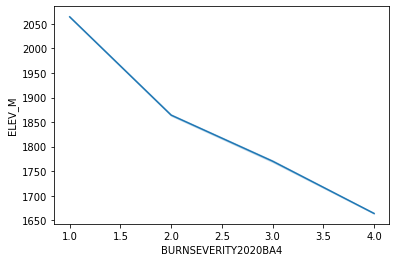

In [33]:
sns.lineplot(data=df_creek_graph, x="BURNSEVERITY2020BA4", y="ELEV_M")

### df_creek coorelation matrix

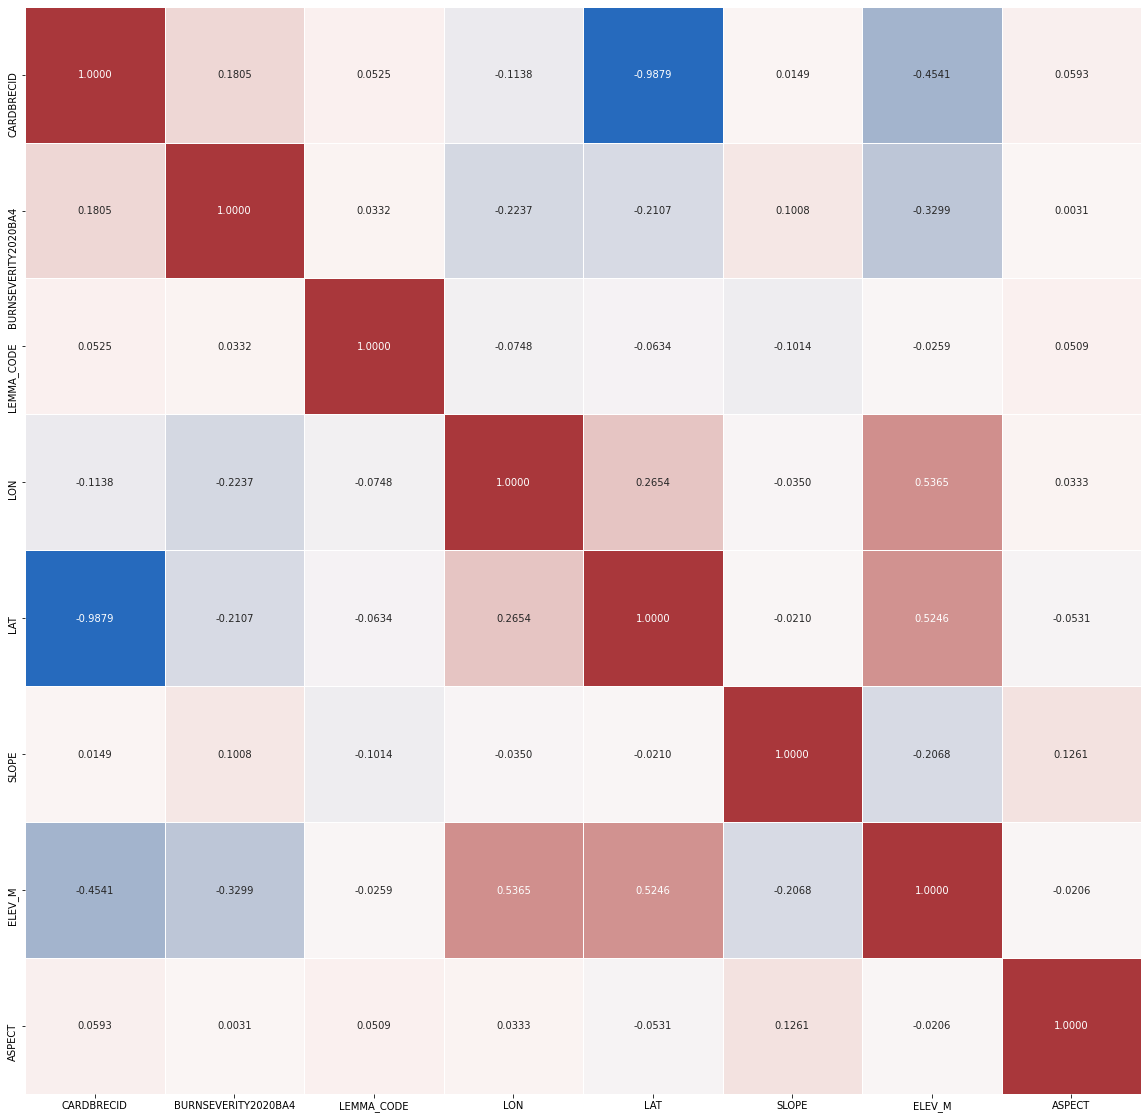

In [56]:
plt.rc('figure', figsize=(10,10))
corrMatrix = df_creek.corr()
ax = sns.heatmap(corrMatrix, annot=True, cmap="vlag", linewidths=1, cbar=False, center=0,fmt=".4f") 

plt.show()

### df_castle coorelation matrix

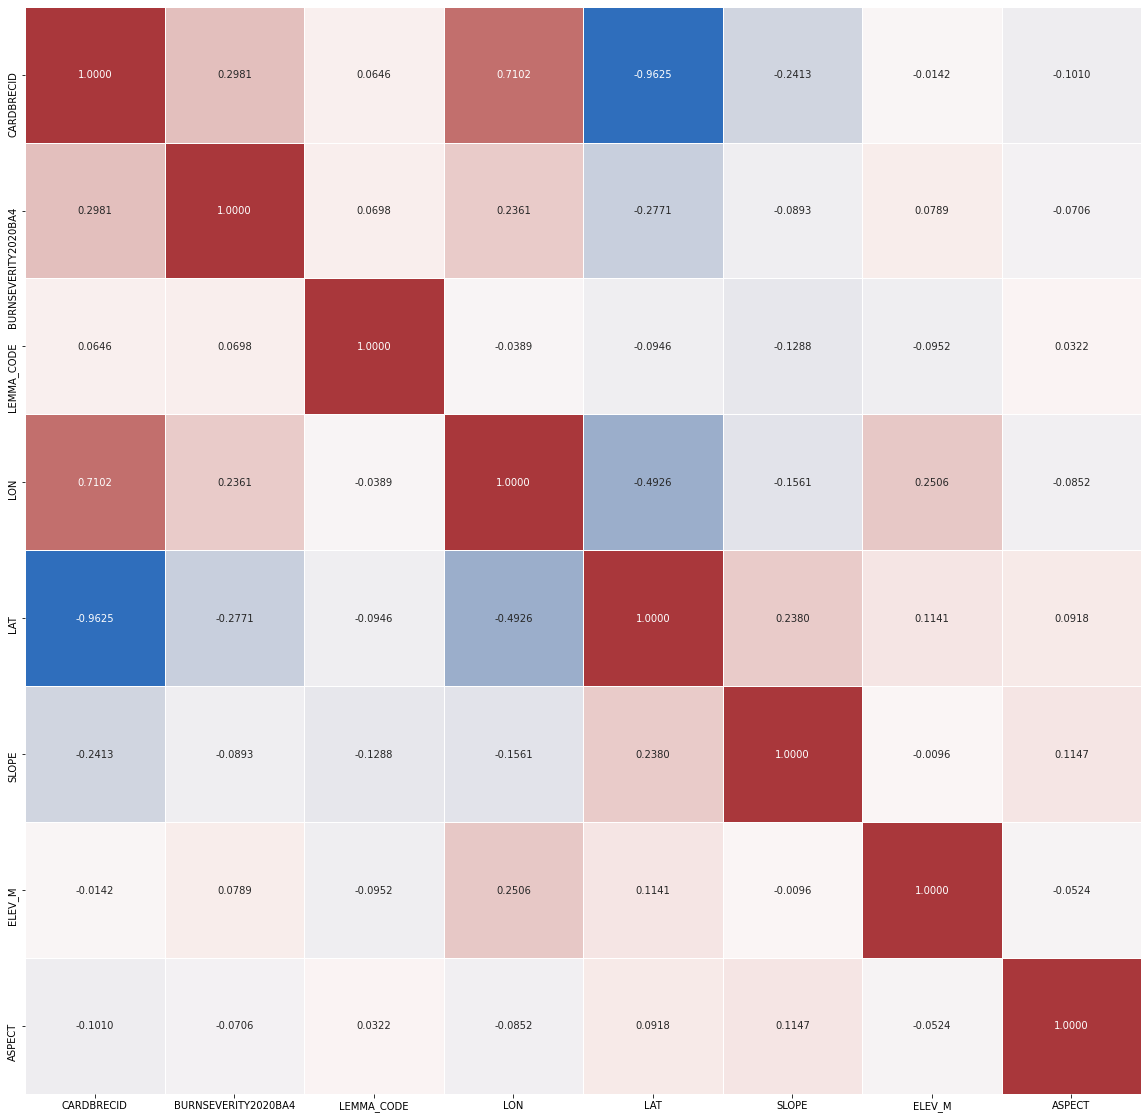

"\nValueError: 'YlGnRd' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolw

In [57]:
plt.rc('figure', figsize=(10,10))
corrMatrix = df_castle.corr()
ax = sns.heatmap(corrMatrix, annot=True, cmap="vlag", linewidths=1, cbar=False, center=0,fmt=".4f") 

plt.show()

'''
ValueError: 'YlGnRd' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
'''

### df_claremont coorelation matrix

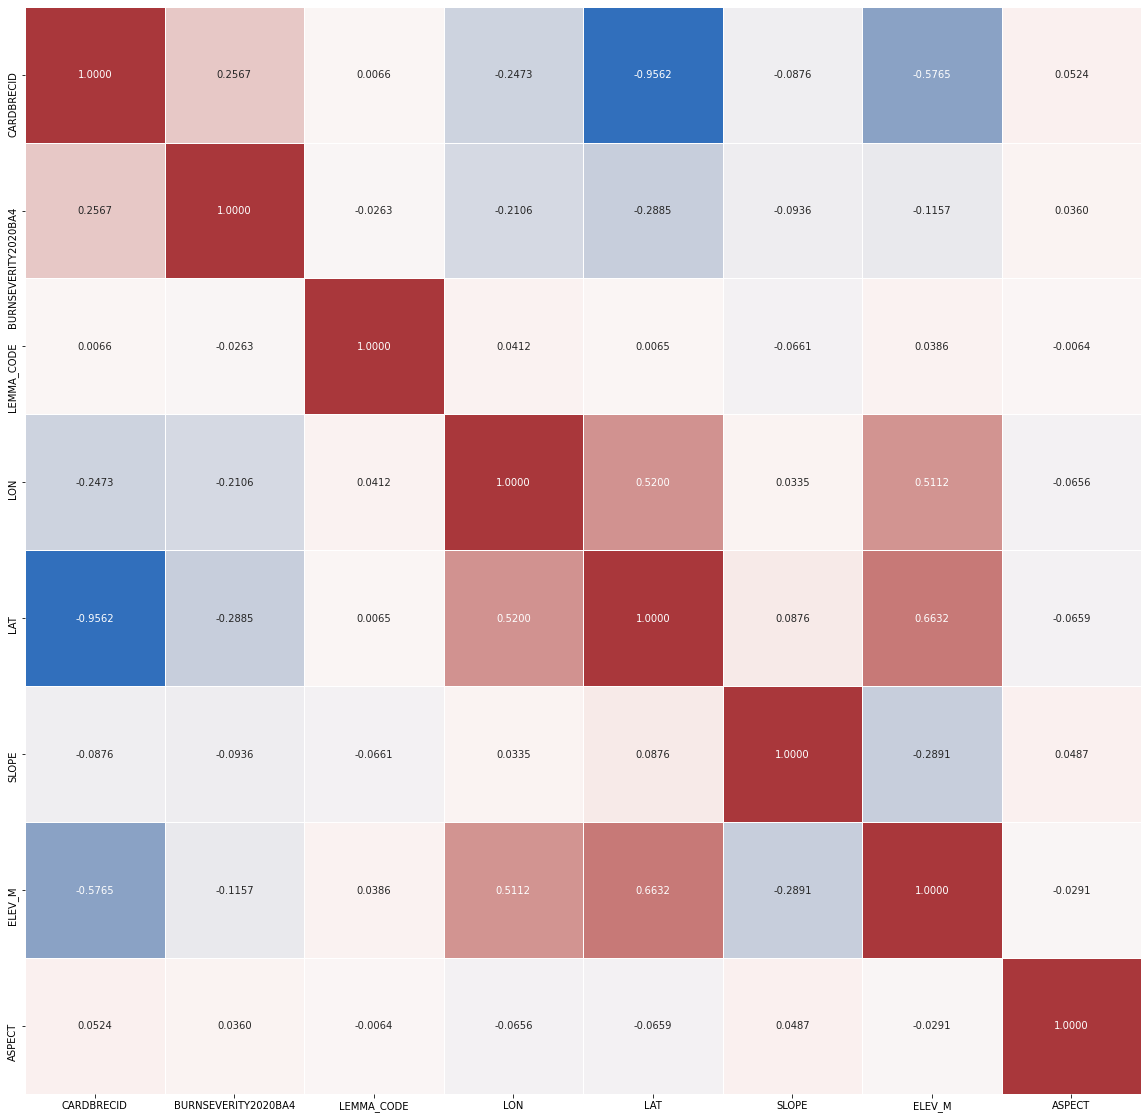

In [60]:
plt.rc('figure', figsize=(10,10))
corrMatrix = df_claremont.corr()
ax = sns.heatmap(corrMatrix, annot=True, cmap="vlag", linewidths=1, cbar=False, center=0,fmt=".4f") 

plt.show()

## Modeling
### [Ordinal logistic regression](https://rikunert.com/ordinal_rating)

In [61]:
# linear-regression vs logistic-regression 
from sklearn.linear_model import LinearRegression, LogisticRegression 
from mord import LogisticAT  

# Build models

model_linear = LinearRegression()
model_ovr = LogisticRegression(multi_class='ovr', class_weight='balanced')
model_mul = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
# alpha set to zero - to perform no regularisation
model_ordinal = LogisticAT(alpha=0)  


In [62]:
# /opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning. FutureWarning) 
#https://stackoverflow.com/questions/52640386/how-do-i-solve-the-future-warning-min-groups-self-n-splits-warning-in 
# import warnings warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
# import numpy as np

# divide df_regression into features matrix and target vector
features = df_regression.iloc[:, 1:]  
target = df_regression['BURNSEVERITY2020BA4']

In [67]:
# Mean Absolute Error
MAE = make_scorer(mean_absolute_error)

In [66]:
MAE_linear = cross_val_score(model_linear, features, target, cv=5, scoring=MAE)
print('MAE on Linear regression: ', np.mean(MAE_linear)) 

Linear regression:  1.057614563916638


In [73]:
MAE_ovr = cross_val_score(model_ovr, features, target, cv=5, scoring=MAE)
print('MAE on Logistic regression - one versus rest: ', np.mean(MAE_ovr))

MAE on Logistic regression - with one versus rest:  1.2275316746268008


In [76]:
MAE_mul = cross_val_score(model_mul, features, target, cv=5, scoring=MAE)
print('MAE on Logistic regression - multinomial: ', np.mean(MAE_mul))

MAE on Logistic regression - multinomial:  1.2774694761992893


In [ ]:
MAE_ordinal = cross_val_score(model_ordinal, features, target, cv=5, scoring=MAE)
print('MAE on Ordered logistic regression: ', np.mean(MAE_ordinal))

In [ ]:
#1.2866425269393578
#1.1605505923135953 

In [77]:
from sklearn.metrics import accuracy_score  

def get_accuracy_score(target_true, target_fit):
    target_fit = np.round(target_fit)
    target_fit.astype('int')
    return accuracy_score(target_true, target_fit)

acc = make_scorer(get_accuracy_score)

'Accuracy:'

'Accuracy:'

In [78]:
acc_linear = cross_val_score(model_linear, features, target, cv=5, scoring=acc)
print('Linear regression: ', np.mean(acc_linear)) 

Linear regression:  0.15010354680977267


In [79]:
acc_ovr = cross_val_score(model_ovr, features, target, cv=5, scoring=acc)
print('Logistic regression (one versus rest): ', np.mean(acc_ovr))

Logistic regression (one versus rest):  0.4093698164095933


In [ ]:
acc_multi = cross_val_score(model_mul, features, target, cv=5, scoring=acc)
print('Logistic regression (multinomial): ', np.mean(acc_multi)) 

In [ ]:
acc_ordinal = cross_val_score(model_ordinal, features, target, cv=5, scoring=acc)
print('Ordered logistic regression: ', np.mean(acc_ordinal))

In [ ]:
# 0.14964767652817043 
# 0.3765488273342543 

### [Decision Tree](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)

In [110]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics, tree

* [Understanding decision tree classification with scikit learn](https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd)

In [81]:

labels = df['EVT_FUEL_N'].astype('category').cat.categories.tolist()
replace_evt = {'EVT_FUEL_N' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
replace_evt1

{'EVT_FUEL_N': {'Ba Open Water': 1,
  'Bab Barren': 2,
  'Bau Developed-High Intensity': 3,
  'Bau Developed-Low Intensity': 4,
  'Bau Developed-Medium Intensity': 5,
  'Bau Developed-Roads': 6,
  'Dab Pasture and Hayland': 7,
  'Dgr Developed Ruderal Grassland': 8,
  'Dgr Urban Herbaceous': 9,
  'Dsh Developed Ruderal Shrubland': 10,
  'Dsh Urban Shrubland': 11,
  'Dtc Developed Ruderal Evergreen Forest': 12,
  'Dtc Urban Evergreen Forest': 13,
  'Dtd Developed Ruderal Deciduous Forest': 14,
  'Dtd Urban Deciduous Forest': 15,
  'Dtm Urban Mixed Deciduous-Evergreen Forest': 16,
  'He Inter-Mountain Basins Semi-Desert Grassland': 17,
  'He Introduced Upland Vegetation-Annual Grassland': 18,
  'He Mediterranean California Subalpine Meadow': 19,
  'He North Pacific Montane Grassland': 20,
  'Sh Artemisia tridentata ssp. vaseyana Shrubland Alliance': 21,
  'Sh California Mesic Chaparral': 22,
  'Sh California Montane Woodland and Chaparral': 23,
  'Sh California Xeric Serpentine Chaparral

In [82]:
df_replace = df.copy()
df_replace.replace(replace_evt, inplace=True)
df_replace.head()

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,107391771,4,105029,-121.29380,39.70192,"{\n ""coordinates"": [\n -1.212938000000000e...",50,21,1213,171,Claremont-Bear
1,107414266,3,77092,-121.29974,39.70014,"{\n ""coordinates"": [\n -1.212997400000000e...",50,7,1165,345,Claremont-Bear
2,107414369,4,104200,-121.26466,39.70739,"{\n ""coordinates"": [\n -1.212646600000000e...",53,38,701,183,Claremont-Bear
3,107538145,3,104365,-121.26806,39.70363,"{\n ""coordinates"": [\n -1.212680600000000e...",46,31,593,280,Claremont-Bear
4,107560672,4,68183,-121.25868,39.70502,"{\n ""coordinates"": [\n -1.212586800000000e...",46,33,743,342,Claremont-Bear


In [83]:
df_replace['EVT_FUEL_N'].dtypes

dtype('int64')

In [84]:
# feature
feature_cols = ['EVT_FUEL_N','LEMMA_CODE','SLOPE', 'ELEV_M','ASPECT']
X = df_replace[feature_cols]  
# target
Y = df_replace.BURNSEVERITY2020BA4

In [85]:
# 70% training and 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1) 

In [92]:
# Create Decision Tree classifer object & train Decision Tree Classifer 
dtc = DecisionTreeClassifier()  
dtc = dtc.fit(X_train,Y_train)  

#Predict the response for test dataset 
Y_pred = dtc.predict(X_test)

In [93]:
# Model Accuracy = TP/(TP+FP+TN+FN)
metrics.accuracy_score(Y_test, Y_pred)

0.47018261276140055

In [108]:
# Confusion Matrix
severity = np.array(Y_test)
predictions = np.array(Y_pred)

confusion_matrix = metrics.confusion_matrix(severity, predictions)
confusion_matrix

array([[ 96611,  45801,  24075,  56174],
       [ 45421,  53138,  31223,  60534],
       [ 22640,  30833,  29192,  57504],
       [ 59146,  65724,  62968, 319840]])

In [111]:
tree.plot_tree(dtc)

#  Ran over 2 hours....

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [ ]:
# Decision tree classifer - 2 
dtc2 = DecisionTreeClassifier(max_depth=6)  
# Train Decision Tree Classifer 
dtc2 = dtc2.fit(X_train, Y_train)  
# Predict the response for test dataset 
Y_pred2 = dtc2.predict(X_test)  

# Model2 Accuracy
metrics.accuracy_score(Y_test, Y_pred2)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [ ]:
tree.plot_tree(dtc2)

In [ ]:
# Decision tree classifer 3
dtc3 = DecisionTreeClassifier(max_depth=6)  
# Train Decision Tree Classifer 
dtc3 = dtc3.fit(X_train, Y_train)  
# Predict the response for test dataset 
Y_pred3 = dtc3.predict(X_test)  

# Model3 Accuracy
metrics.accuracy_score(Y_test, Y_pred2)

### Visualize decision tree 1

In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data, feature_names=feature_cols) 
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

### [Decision tree in Python](https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93)

### Hot spot analysis (Still having trouble in this part)
* [Ref1](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/hot-spot-analysis.htm)
* [Ref2](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/hot-spot-analysis.htm#GUID-962A2207-58C5-4D3A-AD16-A8588AB5692E)

In [123]:
sdf = pd.DataFrame.spatial.from_xy(df, x_column = 'LON', y_column = 'LAT', sr=4326)
sdf.head()

AttributeError: type object 'DataFrame' has no attribute 'spatial'

### for ArcGIS Online:
* [create a geodatabase](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/create-file-gdb.htm#C_GUID-DB1C0BE8-EE77-4253-A7D2-7CCC5F803A7C):
* /arcgis/home/hotspot/df_hotspot.gdb

In [ ]:
os.mkdir('/arcgis/home/hotspot')
arcpy.CreateFileGDB_management('/arcgis/home/hotspot', 'df_hotspot.gdb')

In [ ]:
# create a new feature class "san_diego_airbnb_listings_for_analysis" and add it to our geodatabase 
sdf.spatial.to_featureclass(location=r'/arcgis/home/hotspot/df_hotspot.gdb/sdf_hotspot_analysis')

# check data exist
file_geodatabase = env.workspace = ('/arcgis/home/hotspot/df_hotspot.gdb')
list_features = arcpy.ListFeatureClasses() 
list_features

# Set the path to the "df_hotspot" data 
df_hotspot_data = file_geodatabase + '/sdf_hotspot_analysis'

In [ ]:
sdf_data_prj = file_geodatabase + '/sdf_hotspot_analysis'
sdf_fire_HS1 = arcpy.stats.HotSpots(sdf_data_prj,"BURNSEVERITY2020BA4", "{0}//{1}".format(file_geodatabase,"sdf_fire_HS1"), )
for i in range(0, sdf_fire_HS1.messageCount):
    print(sdf_fire_HS1.getMessage(i))

In [ ]:
sdf_fire_HS1.getOutput(0)

In [ ]:
file_geodatabase = env.workspace = ('/arcgis/home/hotspot/df_hotspot.gdb')
sdf2 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/sdf_fire_HS1')
sdf2.head()

In [ ]:
sdf2.describe().T

In [ ]:
m1 = GIS().map("California")
m1.zoom = 8
m1.center = [37.577260, -120.746980]
sdf2.spatial.plot(map_widget = m1, renderer_type = 'c', class_count = 7, col = 'Gi_Bin', cmap = 'bwr', alpha = 0.7)
m1.legend = True
m1

In [ ]:
# publish spacial dataframe to feature layer  
import time 
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_HS1'+ str(current_date_time)

lyr = sdf2.spatial.to_featurelayer(layer_name)
lyr

### Run clustering analysis

In [ ]:

https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm#GUID-B146C426-4E83-45ED-B6BF-F94586223C31
# arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster, {search_distance}, cluster_sensitivity)

in_features = df_hotspot_data output_features = file_geodatabase + '/DBSCAN_v1' 
cluster_method = "DBSCAN" 
min_features_cluster = 20 
# search_distance =
# cluster_sensitivity =   
arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster)

In [ ]:
sdf1 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/DBSCAN_v1') sdf1.head()
sdf1.head()

In [ ]:
sdf1.describe().T

In [ ]:
m1 = GIS().map("California")
m1.zoom = 8
m1.center = [39,-117]
sdf1.spatial.plot(map_widget = m1,
                renderer_type = 'u',  # for unique breaks renderer
                method ='esriClassifyManual', # standardDeviationInterval = 1, # class_count = 7,  # choose the number of classes
                col = 'COLOR_ID',  # numeric column to classify
                cmap = 'gist_ncar',  # color map to pick colors from for each class
                alpha = 0.7,  # specify opacity
                outline_color='binary',
                marker_size = 8,
                line_width = 0.5
                )  
m1.legend = True
m1

In [ ]:

# publish to feature layer
import time 
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_DBSCAN'+ str(current_date_time)
lyr = sdf1.spatial.to_featurelayer(layer_name)
lyr

### [HDBSCAN](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm)
* [REF1](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm)
* [REF2](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm#GUID-B146C426-4E83-45ED-B6BF-F94586223C31)


In [ ]:
# arcpy.stats.DensityBasedClustering(in_features, output_features,  cluster_method, min_features_cluster, {search_distance}, cluster_sensitivity)

in_features = df_hotspot_data
output_features = file_geodatabase + '/HDBSCAN_v1'
cluster_method = "HDBSCAN"
min_features_cluster = 20 
# search_distance =  
# cluster_sensitivity =   
 
arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster)

In [ ]:
sdf2 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/HDBSCAN_v1')
sdf2.head()

In [ ]:
sdf2.describe().T

In [ ]:
m2 = GIS().map("California")
m2.zoom = 8
m2.center = [39,-117] sdf2.spatial.plot(
    map_widget = m2, 
    renderer_type = 'u',  # for unique breaks renderer
    method ='esriClassifyManual',
    # standardDeviationInterval = 1,
    # # class_count = 7,  # choose the number of classes
    col = 'COLOR_ID',  # numeric column to classify
    cmap = 'gist_ncar',  # color map to pick colors from for each class
    alpha = 0.5,  # specify opacity
    outline_color='binary',
    marker_size = 6,
    line_width = 1
        )  
m2.legend = True
m2

In [ ]:
# publish to feature layer  
import time
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_HDBSCAN'+ str(current_date_time)
lyr = sdf1.spatial.to_featurelayer(layer_name)
lyr

### OPTICS
* [REF1](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm)
* [REF2](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm#GUID-B146C426-4E83-45ED-B6BF-F94586223C31)

In [ ]:
# arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster, {search_distance}, cluster_sensitivity)

in_features = df_hotspot_data
output/_features = file_geodatabase + '/OPTICS_v1' cluster_method = "OPTICS"
min_features_cluster = 20 
# search_distance =  
# cluster_sensitivity =

arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster)

In [ ]:
sdf3 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/OPTICS_v1')
sdf3.head()

In [ ]:
sdf3.describe().T

In [ ]:
m3 = GIS().map("California")
m3.zoom = 8
m3.center = [39,-117]
sdf3.spatial.plot(
    map_widget = m3,
    renderer_type = 'u',  # for unique breaks renderer
    method ='esriClassifyManual',
    # standardDeviationInterval = 1,
    class_count = 5,
    col = 'COLOR_ID',
    cmap = 'gist_ncar',
    alpha = 0.7,  # specify opacity
    outline_color='binary',
    marker_size = 8,
    line_width = 0.5
)
m3.legend = True
m3

In [ ]:
# publish to feature layer 
import time
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_OPTICS'+ str(current_date_time)
lyr = sdf1.spatial.to_featurelayer(layer_name)
lyr